In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 
from pathlib import Path


#Please import the folder bee_wing_photos_cropped_0508 into your working directory
file_path = os.path.join(Path(os.getcwd()).parent, 'bee_wing_photos_cropped_0508')

def read_files(file_path):
    df = pd.DataFrame({
        'serial':[],
        'species':[],
        'side':[],
        'image_path':[]
    })

    for species_name in os.listdir(file_path):
        species_path = os.path.join(file_path, species_name)
        
        for image_name in os.listdir(species_path):
            if not image_name.lower().endswith((".jpg",".png")):
                continue

            image_path = os.path.join(species_path, image_name)

            observation = dict()
            observation['species'] = [species_name]
            observation['image_path'] = [image_path]
            
            start_idx = image_name.find("-")
            end_idx = image_name.find("_")
            observation['serial'] = [image_name[start_idx+1:end_idx]]
            observation['side'] = [image_name[end_idx+1]]
            
            img = cv2.imread(image_path)
            #observation['img_arr'] = [img.tolist()]
            observation['img_height'] = [img.shape[0]]
            observation['img_weights'] = [img.shape[1]]

            df = pd.concat([df, pd.DataFrame(observation)])

    df.set_index('serial')
    print('df shape:', df.shape)
    return df 

beewings_df = read_files(file_path)



beewings_df.head()

df shape: (618, 6)


,serial,species,side,image_path,img_height,img_weights
0,IZC00008208,Agapostemon texanus,L,c:\Users\17075\Desktop\Code for beginner\Proje...,169.0,479.0
0,IZC00008208,Agapostemon texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...,148.0,465.0
0,IZC00012323,Agapostemon texanus,L,c:\Users\17075\Desktop\Code for beginner\Proje...,157.0,382.0
0,IZC00012323,Agapostemon texanus,R,c:\Users\17075\Desktop\Code for beginner\Proje...,143.0,390.0
0,IZC00012454,Agapostemon texanus,L,c:\Users\17075\Desktop\Code for beginner\Proje...,148.0,446.0


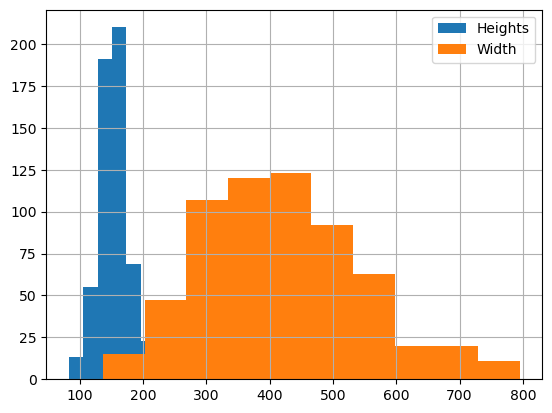

In [9]:
beewings_df['img_height'].hist(label='Heights')
beewings_df['img_weights'].hist(label='Width')
plt.legend()



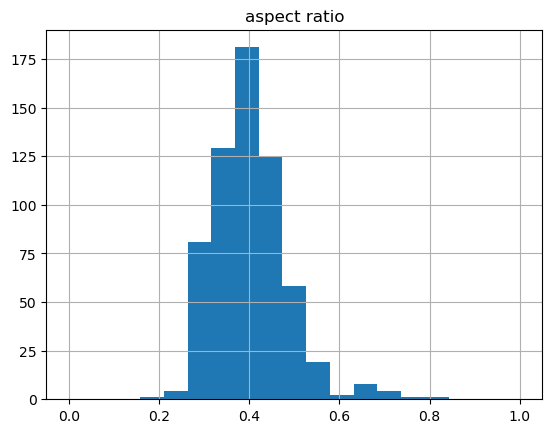

In [10]:
(beewings_df['img_height'] / beewings_df['img_weights']).hist(bins=np.linspace(0, 1, 20))
plt.title('aspect ratio')

h = int(beewings_df['img_height'].mean())
w = int(beewings_df['img_weights'].mean())

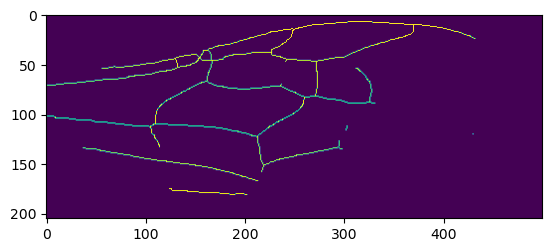

In [14]:
def skeletonize_image(img):
    image_chosen = img.copy()
    r = 500.0 / image_chosen.shape[1]
    dim = (500, int(image_chosen.shape[0] * r))
    image_chosen = cv2.resize(image_chosen, dim, interpolation=cv2.INTER_AREA)

    #gray scale + bluring. 
    image_chosen_gray = cv2.cvtColor(image_chosen, cv2.COLOR_BGR2HSV)[:,:,-1]
    image_chosen_gray = image_chosen[:,:,-1].copy()

  
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3,3))
    #image_chosen_gray = clahe.apply(image_chosen_gray)

    se=cv2.getStructuringElement(cv2.MORPH_RECT , (3,3))
    bg=cv2.morphologyEx(image_chosen_gray, cv2.MORPH_DILATE, se)
    #image_chosen_gray=cv2.divide(image_chosen_gray, bg, scale=255)


    image_chosen_gray_blur = cv2.medianBlur(image_chosen_gray,3)
    image_chosen_gray_blur = cv2.bilateralFilter(image_chosen_gray_blur, 3, 50, 50)
    divide = cv2.divide(image_chosen_gray, image_chosen_gray_blur, scale=255)
    th = cv2.adaptiveThreshold(image_chosen_gray_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,3,1,)

    _, th2 = cv2.threshold(divide,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    noise_remove = th.copy()
    noise_remove = cv2.medianBlur(noise_remove, 3)
    noise_remove = cv2.dilate(noise_remove, np.full(3,3),255)
    contours, hierarchy = cv2.findContours(noise_remove, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE,)
    filtered_contours = [i for i in contours if cv2.contourArea(i) < 20]
    noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)
    contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
    kernel = np.full((5,5), 255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    noise_remove = cv2.morphologyEx(noise_remove, cv2.MORPH_CLOSE, kernel, iterations=1)

 
    ### return by grayscale!!
    sharpened_image = np.zeros_like(image_chosen_gray)
    sharpened_image[noise_remove == 255] = image_chosen_gray[noise_remove == 255]
    sharpened_image[noise_remove == 0] = image_chosen_gray_blur[noise_remove == 0]


    #Repeat step 2 and 3 
    sharpened_image_copy = sharpened_image.copy()
    sharpened_image_copy = cv2.medianBlur(sharpened_image_copy,3)
    sharpened_image_copy = cv2.bilateralFilter(sharpened_image_copy, 3, 50, 50)

    th = cv2.adaptiveThreshold(sharpened_image_copy,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,3,2,)
    noise_remove = th.copy()


    contours, _ = cv2.findContours(noise_remove, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE,)
    filtered_contours = [i for i in contours if cv2.contourArea(i) < 10]
    noise_remove = cv2.drawContours(noise_remove, filtered_contours, -1, 0, cv2.FILLED)

   
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    noise_remove = cv2.morphologyEx(noise_remove, cv2.MORPH_DILATE, kernel, iterations=1)

    des = cv2.bitwise_not(noise_remove)
    contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [i for i in contour if cv2.contourArea(i) < 200]
    for cnt in filtered_contours:
        cv2.drawContours(des,[cnt],0,0,-1)
    noise_remove = cv2.bitwise_not(des)


    ## thinning, https://github.com/linbojin/Skeletonization-by-Zhang-Suen-Thinning-Algorithm
    from thin import zhangSuen
    skinny = zhangSuen(noise_remove/255) * 255
    skinny = skinny.astype('uint8')
    return skinny

plt.imshow(skeletonize_image(cv2.imread(beewings_df.image_path.iloc[2])))

In [15]:
data_arr = []
for i in beewings_df.image_path:
    img = cv2.imread(i)
    img = skeletonize_image(img)
    img = cv2.resize(img, (h,w))
    data_arr.append(img)
    
data_arr = np.array(data_arr)
data_arr.shape
    

(618, 420, 163)

In [17]:

np.save('img_pixels.npy',data_arr.reshape(len(data_arr), -1))
#import csv
#with open("img_pixels.csv", 'a') as f:
#    writer = csv.writer(f) 
#    for value in data_arr.reshape(len(data_arr), -1):
#        print(value.shape)
#        writer.writerow(value)


https://github.com/jmbr/diffusion-maps
Run in Terminal the following command: diffusion-maps img_pixels.npy 1 --plot  

Eigen value and vectors stored in eigenvalues.dat and eigenvectors.npy
flattened skeletonized iage stored in img_pixels.npy

Conclusion: Eigen values are all 1 in diffusion mapping; No information can be found from flattening raw cropped images nor skeletonized images by treating pixels as features; This could be due to spatial information being lost during flattening, as well as non-standardized nature of image data;